# Imports

In [1]:
import torch, sys, math
import numpy as np
from torch.autograd import Variable
from torchviz import make_dot
import torch.nn.functional as F
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go

# Generate Data

We want to create a dataset that effectively combine data from two very different functions.

- Dataset one comes from a sinusoidal function, and oscillates between -1 and 1. To fit this data, a model requires a non-linearity. 
- Dataset two comes from a linear function. To fit this data, a model simply requires having the same domain as the data.

In [54]:
def sinusoidal_data(x):
    return np.sin(x)**3

def linear_data(x):
    return 2*x + 5

x   = np.linspace(-5,5,1000, dtype=np.float32)
y_1 = sinusoidal_data(x[(x>=-1) & (x<=1)])
y_2 = linear_data(x[(x<=-1) | (x>=1)])

y = np.concatenate((y_1, y_2))

# Models

We effectively want three separate models: 2 "experts" and 1 "router" which will route the input data to the appropriate expert. 

To start off, instead of the router model actually routing, we'll feed the data to both experts, as well as the router. The router's output activation is a softmax, which will indicate which expert's output we ought to use. 

To simulate two experts in different domains, we'll have one expert capable of handling non-linear data, but only in the domain (-1, 1). The other expert will only be able to model linear data, but is not bound. 

The idea is the router ought to learn to route data between -1 and 1 to expert 1 while other data gets routed to expert 2.

In [136]:
# Generic Regression Class
class Regression(torch.nn.Module):
    
    def __init__(self, input_dims, output_dims, output_activation, hidden_dims=250):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, hidden_dims)
        self.h1           = torch.nn.Linear(hidden_dims, hidden_dims)
        self.output_layer = torch.nn.Linear(hidden_dims, output_dims)
        self.output_activation = output_activation
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
        out = self.h1(out)
        out = F.relu(out)
        
        out = self.output_layer(out)
        out = self.output_activation(out) if self.output_activation != None else out
        return out

# Expert Curve has non-linerities, but is bound between -1 & 1
class Expert_Curve(torch.nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, 250)
        self.h1           = torch.nn.Linear(250, 250)
        self.output_layer = torch.nn.Linear(250, output_dims)
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
        out = self.h1(out)
        out = F.relu(out)
        
        out = self.output_layer(out)
        out = torch.tanh(out)
        return out

# Expert Linear can only work with linear data, but is unbound
class Expert_Linear(torch.nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, 25)
        self.output_layer = torch.nn.Linear(25, output_dims)
        
    def forward(self, x):
        out = self.input_layer(x)
        out = self.output_layer(out)
        return out

# Router model will return a softmax, weighing how much weight to place on each expert
class Router(torch.nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, 250)
        self.h1           = torch.nn.Linear(250, 250)
        self.output_layer = torch.nn.Linear(250, 2)
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
        out = self.h1(out)
        out = F.relu(out)
        
        out = self.output_layer(out)
        out = F.softmax(out, dim=1)
        return out

## Testing the experts

Let's test each expert out in their own domain

In [163]:
class Agent_Expert():
    def __init__(self, expert_model, lr=0.001):
        
        self.expert    = expert_model(1, 1)
        self.loss_fn   = torch.nn.MSELoss() 
        self.optimizer = torch.optim.Adam(self.expert.parameters(), lr=lr)
        self.loss      = None
        self.losses    = []
        
    def predict(self, x):
        x = torch.from_numpy(x)
        predictions = self.expert(x)
        return predictions.detach().numpy()
    
    def fit(self, x, y):

        shuffled_idx = np.arange(0, len(x))
        np.random.shuffle(shuffled_idx)
        x = x[shuffled_idx]
        y = y[shuffled_idx]
        
        batch_size = len(x) // 25
        
        for epoch in tqdm(range(100)):
            for batch in range(batch_size):
                x_train = x[batch * batch_size : (batch+1) * batch_size]
                y_train = y[batch * batch_size : (batch+1) * batch_size]
                inputs  = Variable(torch.from_numpy(x_train))
                labels  = Variable(torch.from_numpy(y_train))
                
                self.optimizer.zero_grad()
                predictions = self.expert(inputs)
                loss        = self.loss_fn(predictions, labels)
                loss.backward()
                self.loss = loss
                self.optimizer.step()

                # Save loss (filter out NaNs)
                loss_value = loss.item()
                if not math.isnan(loss_value):
                    self.losses.append(loss_value)
        # Display Loss
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=self.losses, mode='lines', name='Loss'))
        fig.show()
    
    def validate(self, x, y):
        predictions = self.predict(x)
        mse = np.mean((predictions - y)**2)
        
        fig = go.Figure()
        fig.update_layout(title=f"MSE Loss: {mse}")
        fig.add_trace(go.Scatter(x=x.squeeze(), y=y.squeeze(), mode='lines', name='actual'))
        fig.add_trace(go.Scatter(x=x.squeeze(), y=predictions.squeeze(), mode='markers', name='predicted'))
        fig.show()

### Sinusoidal Trial

In [164]:
x = np.linspace(-5,5,2000, dtype=np.float32)
y = sinusoidal_data(x)

sin_agent = Agent_Expert(Expert_Curve)
sin_agent.fit(x[np.newaxis].T, y[np.newaxis].T)

In [165]:
sin_agent.validate(x[np.newaxis].T, y[np.newaxis].T)

### Linear Trial

In [166]:
x = np.linspace(-5,5,2000, dtype=np.float32)
y = linear_data(x)

lin_agent = Agent_Expert(Expert_Linear)
lin_agent.fit(x[np.newaxis].T, y[np.newaxis].T)

In [167]:
lin_agent.validate(x[np.newaxis].T, y[np.newaxis].T)

### Router Trial

In [168]:
# Recall, we want the space between -1 and 1 to be covered by our sinusoidal expert and the rest, linear
x = np.linspace(-5,5,2000, dtype=np.float32)
y = np.array([[1, 0] if (i>=-1 and i<=1) else [0,1] for i in x], dtype=np.float32)

rtr_agent = Agent_Expert(Router)
rtr_agent.fit(x[np.newaxis].T, y)

# Combining the Models

In [61]:
agent = Agent(dim_shape=(1, 1), lr=0.001)
agent.fit(x, y, epochs=100, batch_size=100)

In [60]:
class Agent():
    
    def __init__(self, dim_shape, lr=0.001):
        self.input_dim, self.output_dim  = dim_shape
        
        self.expert_curve = Expert_Curve(self.input_dim, self.output_dim)
        self.expert_linear = Expert_Linear(self.input_dim, self.output_dim)
        self.router_model   = Router(self.input_dim)
        
        self.loss_fn   = torch.nn.MSELoss() 
        self.optimizer = torch.optim.Adam(
            list(self.expert_curve.parameters()) + \
            list(self.expert_linear.parameters()) + \
            list(self.router_model.parameters()) \
            , lr=lr)

        self.loss = None
        self.losses = []
        
        self.expert_used = []

    def predict(self, x, return_tensor = False):
        x = torch.from_numpy(x)
        
        out_1 = self.expert_curve(x)
        out_2 = self.expert_linear(x)
        out_r = torch.unsqueeze(torch.argmax(self.router_model(x), dim=1), 1)

        predictions = torch.where(out_r == 1, out_2, out_1)

        # Record which expert was used
        self.expert_used = out_r.detach().numpy()

        if return_tensor:
            return predictions.detach().numpy(), predictions
        return predictions.detach().numpy()
        
    def fit(self, x, y, epochs=100, batch_size=None, graph_loss=True):
        
        # shuffle data
        shuffled_idx = np.arange(0, len(x))
        np.random.shuffle(shuffled_idx)
        
        x = x[shuffled_idx]
        y = y[shuffled_idx]
        
        batch_size = batch_size if batch_size != None else len(x) // 10
        
        with tqdm(total=epochs, file=sys.stdout) as pbar:
            for epoch in range(1, epochs+1):
                for batch in range(len(x) // batch_size):
                    
                    # *** NUMPY DATA => TORCH TENSORS ***
                    
                    # Get training batch and reshape to [[0], [1], ..., [n]]
                    x_train = x[batch * batch_size : (batch+1) * batch_size][np.newaxis].T
                    y_train = y[batch * batch_size : (batch+1) * batch_size][np.newaxis].T
                    # Convert to torch tensor
                    inputs  = Variable(torch.from_numpy(x_train))
                    labels  = Variable(torch.from_numpy(y_train))
                    
                    # *** TRAINING STEP ***
                    self.optimizer.zero_grad()
                    out_1       = self.expert_curve(inputs)
                    out_2       = self.expert_linear(inputs)
                    out_r       = torch.unsqueeze(torch.argmax(self.router_model(inputs), dim=1), 1)
                    predictions = torch.where(out_r == 1, out_2, out_1)
                    loss        = self.loss_fn(predictions, labels)
                    loss.backward()
                    self.loss = loss
                    self.optimizer.step()
                    
                    # Save loss
                    self.losses.append(loss.item())
                    
                # Update tqdm bar
                pbar.update(1)
                pbar.set_description(f'epoch loss: {np.mean(self.losses[-len(x_train)//batch_size:])}')
        
        if graph_loss:
            fig = go.Figure()
            fig.add_trace(go.Scatter(y=self.losses, mode='lines', name='Loss'))
            fig.show()

    def validate(self, x, y):
        
        predictions = self.predict(x)
        mse = np.mean((predictions - y)**2)
        
        fig = go.Figure()
        fig.update_layout(title=f"MSE Loss: {mse}")
        fig.add_trace(go.Scatter(x=x.squeeze(), y=y.squeeze(), mode='lines', name='actual'))
        fig.add_trace(go.Scatter(x=x.squeeze(), y=predictions.squeeze(), mode='markers', name='predicted'))
        fig.show()

In [62]:
# Prediction
validation_idxs = np.argwhere(x<15)
agent.validate(x[validation_idxs], y[validation_idxs])

In [63]:
one_used_n_times = len(agent.expert_used[agent.expert_used==0])*100 / len(agent.expert_used)
two_used_n_times = len(agent.expert_used[agent.expert_used==1])*100 / len(agent.expert_used)
f'tanh model: {one_used_n_times:.1f}%, linear model: {two_used_n_times:.1f}%'

'tanh model: 100.0%, linear model: 0.0%'

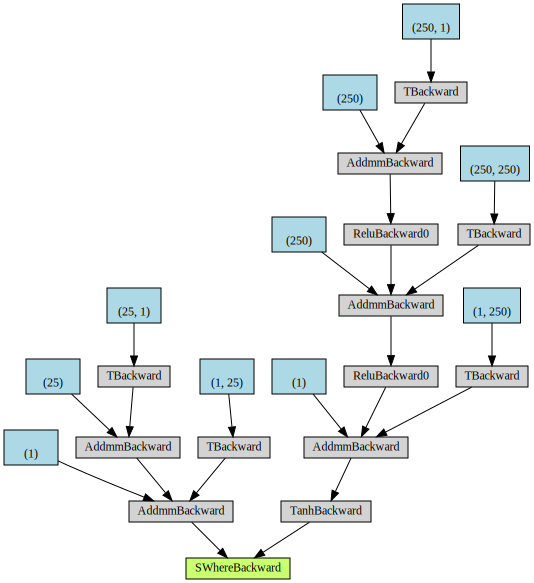

In [64]:
_, out_tensor = agent.predict(np.array([[1]], dtype=np.float32), return_tensor=True)
make_dot(out_tensor)